# データ探索

このノートブックでは、Signateの電力価格予測コンペティションのデータを探索的に分析します。

## 1. 環境設定とデータ読み込み

In [1]:
# 日本語フォントを簡単に使う
!uv pip -q install japanize-matplotlib
import japanize_matplotlib

# 祝日取得
!uv pip install holidays
import holidays

Audited 1 package in 2ms


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# プロジェクトのルートディレクトリを設定
PROJECT_ROOT = Path.cwd()

# データディレクトリのパスを設定
DATA_DIR = PROJECT_ROOT / "data"

print(DATA_DIR)
# データ読み込み用の関数をインポート
from src.data_loader import load_data, preprocess_time, get_feature_groups, check_missing_values, check_outliers

/Users/m0122wt/Desktop/02.プライベート/01.ノウハウ/07.データ分析/notebook/signate_smbc_202506/data


### 1.1 データの読み込み

In [8]:
# データの読み込み
train_df, test_df, feature_desc = load_data(DATA_DIR)

print("訓練データの形状:", train_df.shape)
print("テストデータの形状:", test_df.shape)
print("\n特徴量の説明:")
print(feature_desc)

訓練データの形状: (26280, 91)
テストデータの形状: (8760, 90)

特徴量の説明:
                                           単位  \
特徴量名                                            
time                                        -   
generation_biomass                         MW   
generation_fossil_brown_coal/lignite       MW   
generation_fossil_gas                      MW   
generation_fossil_hard_coal                MW   
...                                       ...   
seville_weather_id                          -   
seville_weather_main                        -   
seville_weather_description                 -   
seville_weather_icon                        -   
price_actual                          EUR/MWh   

                                                                           説明  
特徴量名                                                                           
time                                  時間 (中央ヨーロッパ時間 にローカライズされたDatetimeインデックス)  
generation_biomass                            time列に記載の時刻の24時間前のバイオマス

### 1.2 時間特徴量の前処理

In [9]:
# 時間特徴量の前処理
train_df = preprocess_time(train_df)
test_df = preprocess_time(test_df)

# 時間関連の特徴量を確認
time_features = [col for col in train_df.columns if col in ['hour', 'day_of_week', 'month', 'year']]
print("時間関連の特徴量:")
print(time_features)

時間関連の特徴量:
['hour', 'day_of_week', 'month', 'year']


## 2. 基本情報の確認

### 2.1 データの基本情報

In [10]:
# 訓練データの基本情報
print("訓練データの基本情報:")
train_df.info()

# 数値型の基本統計量
print("\n数値型の基本統計量:")
train_df.describe()

訓練データの基本情報:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2015-01-02 08:00:00+09:00 to 2018-01-01 07:00:00+09:00
Data columns (total 96 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           26259 non-null  float64
 1   generation_fossil_brown_coal/lignite         26260 non-null  float64
 2   generation_fossil_gas                        26260 non-null  float64
 3   generation_fossil_hard_coal                  26260 non-null  float64
 4   generation_fossil_oil                        26259 non-null  float64
 5   generation_hydro_pumped_storage_consumption  26259 non-null  float64
 6   generation_hydro_run_of_river_and_poundage   26259 non-null  float64
 7   generation_hydro_water_reservoir             26260 non-null  float64
 8   generation_nuclear                           26261 non-null  float64
 9   generation_ot

,generation_biomass,generation_fossil_brown_coal/lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run_of_river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,...,seville_rain_3h,seville_snow_3h,seville_clouds_all,seville_weather_id,price_actual,hour,day_of_week,month,day,year
count,26259.000000,26260.000000,26260.000000,26260.000000,26259.000000,26259.000000,26259.000000,26260.000000,26261.000000,26260.000000,...,26280.000000,26280.0,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000,26280.000000
mean,399.151719,480.261729,5559.830122,4447.482216,303.806009,504.322899,888.150844,2507.795316,6323.681200,62.500685,...,0.000243,0.0,13.740601,774.138927,56.028338,11.500000,3.004262,6.526941,15.745814,2016.001826
std,89.897230,365.334152,2272.017312,2027.884207,54.036443,804.870327,369.509637,1869.150134,827.939857,21.451727,...,0.003961,0.0,25.801707,85.866724,14.340356,6.922318,2.001099,3.446585,8.794775,0.816510
min,0.000000,0.000000,1518.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,200.000000,9.330000,0.000000,0.000000,1.000000,1.000000,2015.000000
25%,341.000000,0.000000,4071.000000,2624.000000,268.000000,0.000000,595.000000,955.000000,5900.000000,53.000000,...,0.000000,0.0,0.000000,800.000000,47.617500,5.750000,1.000000,4.000000,8.000000,2015.000000
50%,378.000000,564.000000,4866.000000,4764.000000,303.000000,90.000000,795.000000,1991.000000,6734.000000,58.000000,...,0.000000,0.0,0.000000,800.000000,55.930000,11.500000,3.000000,7.000000,16.000000,2016.000000
75%,480.000000,863.000000,6264.000000,6107.000000,336.000000,696.000000,1148.000000,3666.000000,7071.000000,84.000000,...,0.000000,0.0,20.000000,800.000000,65.192500,17.250000,5.000000,10.000000,23.000000,2017.000000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,1939.000000,9389.000000,7116.000000,106.000000,...,0.095000,0.0,100.000000,804.000000,116.800000,23.000000,6.000000,12.000000,31.000000,2018.000000


### 2.2 欠損値の確認

In [11]:
# 欠損値の確認
missing_values = check_missing_values(train_df, threshold=0.0)
print("欠損値を持つ特徴量:")
print(missing_values)

欠損値を持つ特徴量:
                                             missing_count  missing_ratio
generation_biomass                                      21       0.000799
generation_fossil_brown_coal/lignite                    20       0.000761
generation_fossil_gas                                   20       0.000761
generation_fossil_hard_coal                             20       0.000761
generation_fossil_oil                                   21       0.000799
generation_hydro_pumped_storage_consumption             21       0.000799
generation_hydro_run_of_river_and_poundage              21       0.000799
generation_hydro_water_reservoir                        20       0.000761
generation_nuclear                                      19       0.000723
generation_other                                        20       0.000761
generation_other_renewable                              20       0.000761
generation_solar                                        20       0.000761
generation_waste           

## 3. 時系列データの分析

### 3.1 時間帯ごとの傾向

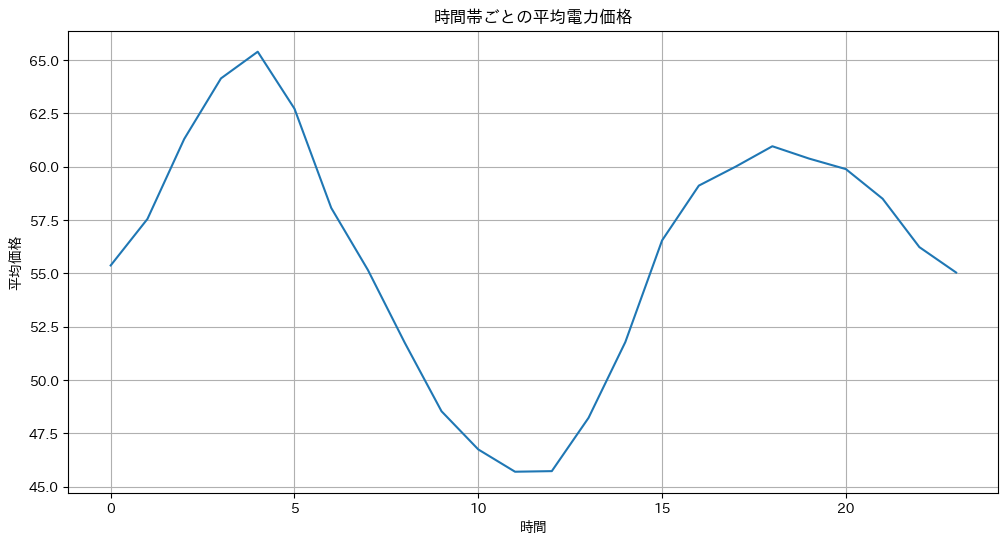

In [12]:
# 時間帯ごとの平均価格
plt.figure(figsize=(12, 6))
train_df.groupby('hour')['price_actual'].mean().plot(kind='line')
plt.title('時間帯ごとの平均電力価格')
plt.xlabel('時間')
plt.ylabel('平均価格')
plt.grid(True)
plt.show()

### 3.2 曜日別の傾向

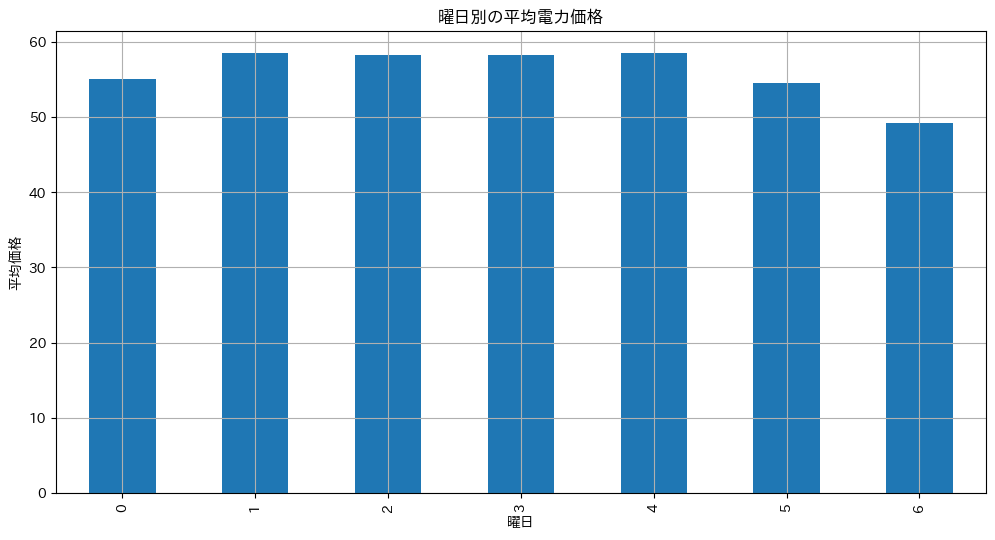

In [13]:
# 曜日別の平均価格
plt.figure(figsize=(12, 6))
train_df.groupby('day_of_week')['price_actual'].mean().plot(kind='bar')
plt.title('曜日別の平均電力価格')
plt.xlabel('曜日')
plt.ylabel('平均価格')
plt.grid(True)
plt.show()

### 3.3 月別の傾向

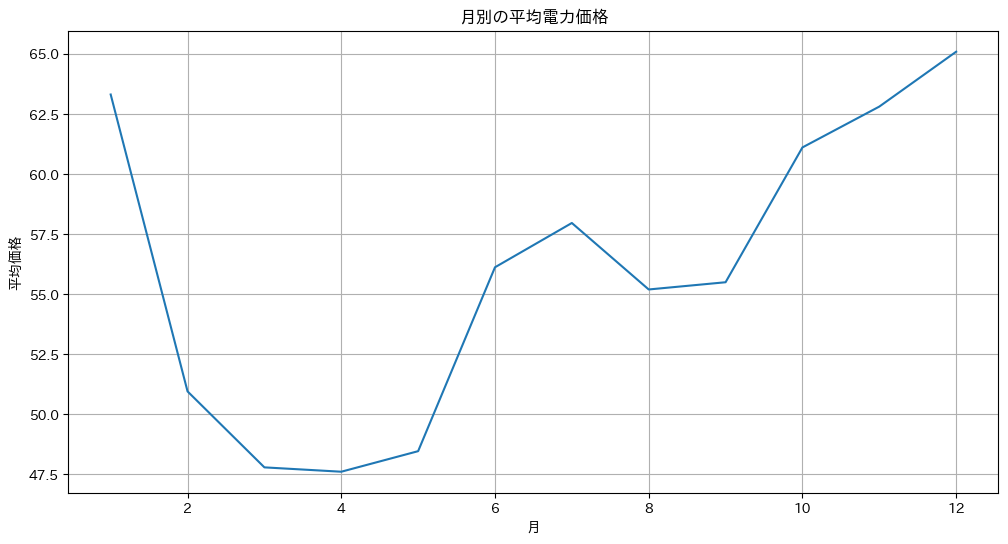

In [14]:
# 月別の平均価格
plt.figure(figsize=(12, 6))
train_df.groupby('month')['price_actual'].mean().plot(kind='line')
plt.title('月別の平均電力価格')
plt.xlabel('月')
plt.ylabel('平均価格')
plt.grid(True)
plt.show()

## 4. 目的変数（電力価格）の分析

### 4.1 価格の分布

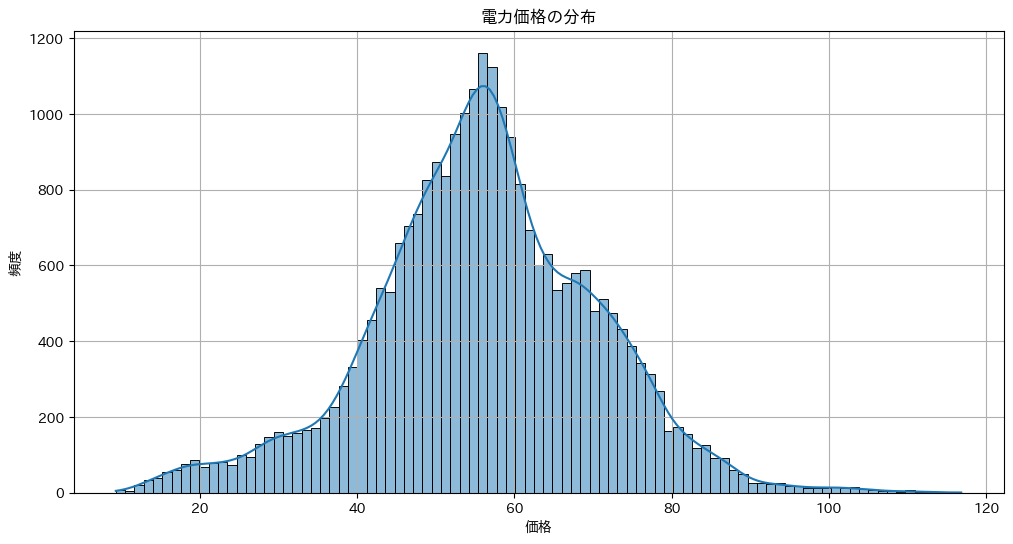

In [15]:
# 価格の分布
plt.figure(figsize=(12, 6))
sns.histplot(train_df['price_actual'], kde=True)
plt.title('電力価格の分布')
plt.xlabel('価格')
plt.ylabel('頻度')
plt.grid(True)
plt.show()

### 4.2 時系列での価格変動

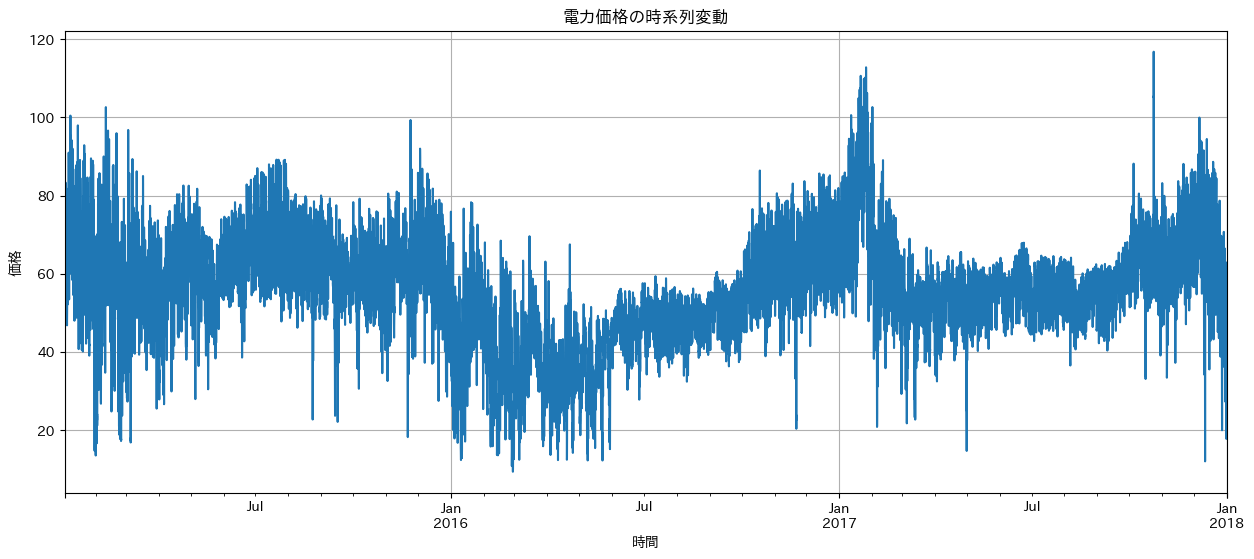

In [16]:
# 時系列での価格変動
plt.figure(figsize=(15, 6))
train_df['price_actual'].plot()
plt.title('電力価格の時系列変動')
plt.xlabel('時間')
plt.ylabel('価格')
plt.grid(True)
plt.show()

## 5. 特徴量の分析

### 5.1 特徴量のグループ化

In [17]:
# 特徴量のグループ化
feature_groups = get_feature_groups(train_df)
for group_name, features in feature_groups.items():
    print(f"\n{group_name}の特徴量:")
    print(features)


timeの特徴量:
['hour', 'day_of_week', 'month', 'day', 'year']

generationの特徴量:
['generation_biomass', 'generation_fossil_brown_coal/lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run_of_river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore']

weatherの特徴量:
['generation_wind_onshore', 'valencia_temp', 'valencia_temp_min', 'valencia_temp_max', 'valencia_pressure', 'valencia_humidity', 'valencia_wind_speed', 'valencia_wind_deg', 'valencia_rain_1h', 'valencia_rain_3h', 'valencia_snow_3h', 'valencia_clouds_all', 'madrid_temp', 'madrid_temp_min', 'madrid_temp_max', 'madrid_pressure', 'madrid_humidity', 'madrid_wind_speed', 'madrid_wind_deg', 'madrid_rain_1h', 'madrid_rain_3h', 'madrid_snow_3h', 'madrid_clouds_all', 'bilbao_temp', 'bilbao_temp_min', 'b

### 5.2 特徴量間の相関

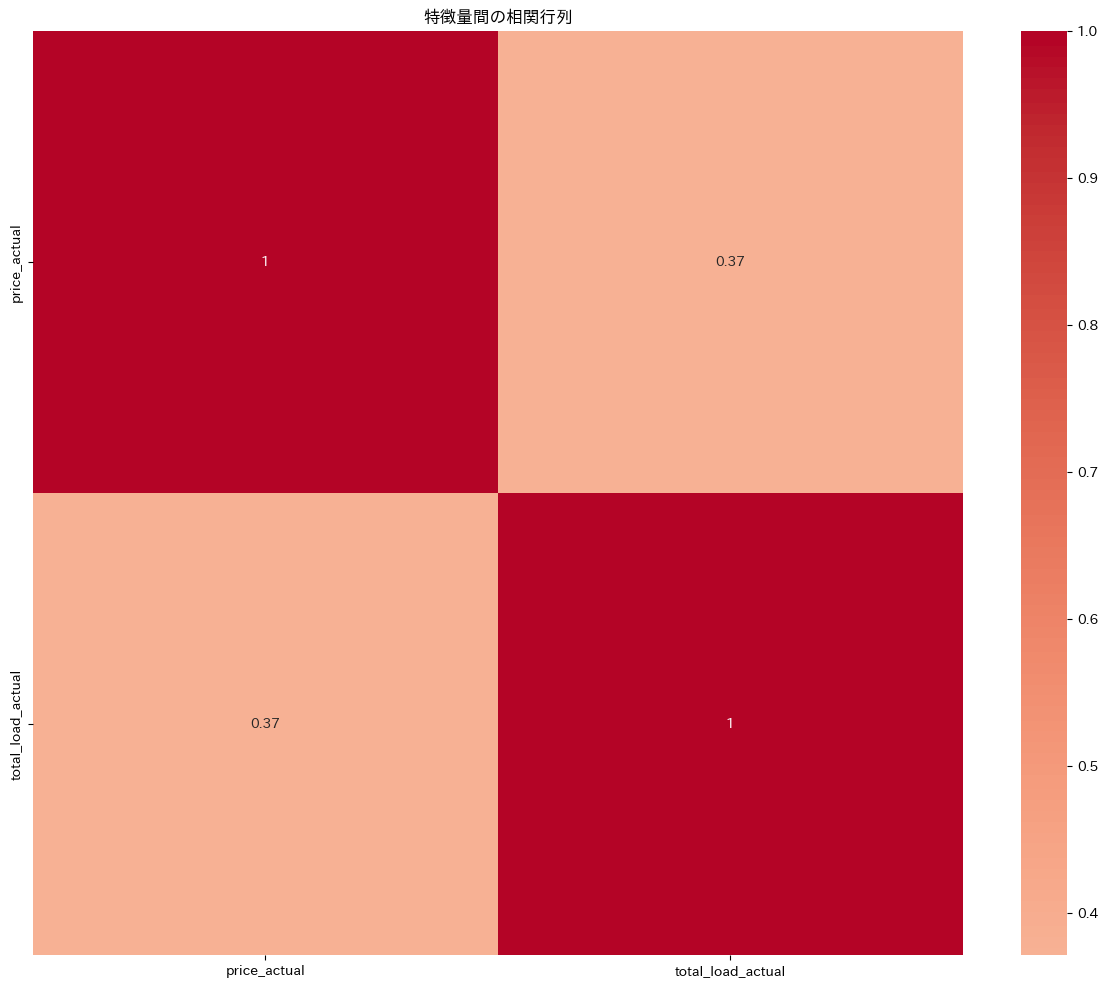

In [18]:
# 特徴量間の相関
plt.figure(figsize=(15, 12))
correlation_matrix = train_df[feature_groups['price_actual'] + feature_groups['load']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('特徴量間の相関行列')
plt.show()

## 6. 外れ値の検出

In [19]:
# 外れ値の検出
outliers = check_outliers(train_df, feature_groups['price_actual'])
print("外れ値を持つ特徴量:")
print(outliers)

外れ値を持つ特徴量:
{'price_actual': {'lower_bound': np.float64(21.255000000000006), 'upper_bound': np.float64(91.55499999999999), 'outlier_count': np.int64(657), 'outlier_ratio': np.float64(0.025)}}


## 7. 初期仮説の設定

### 7.1 特徴量と目的変数の関係性

以下の仮説を検証します：

1. 時間帯による価格変動
   - ピーク時間帯（朝・夕方）は価格が高くなる
   - 深夜は価格が低くなる

2. 曜日による価格変動
   - 平日は価格が高くなる
   - 週末は価格が低くなる

3. 季節による価格変動
   - 夏・冬は価格が高くなる（空調需要の影響）
   - 春・秋は価格が低くなる

4. 発電量と価格の関係
   - 再生可能エネルギー（太陽光・風力）の発電量が増えると価格が下がる
   - 火力発電の発電量が増えると価格が上がる

5. 気象条件と価格の関係
   - 気温が極端に高い/低いと価格が上がる
   - 風速が強いと価格が下がる（風力発電の影響）

6. 需要と価格の関係
   - 需要が増えると価格が上がる
   - 需要が減ると価格が下がる

### 7.2 重要な特徴量の特定

以下の特徴量が重要である可能性が高いと考えられます：

1. 時間関連
   - 時間帯（hour）
   - 曜日（day_of_week）
   - 月（month）

2. 発電関連
   - 太陽光発電量
   - 風力発電量
   - 火力発電量

3. 気象関連
   - 気温
   - 風速
   - 日射量

4. 需要関連
   - 総需要
   - 産業需要
   - 家庭需要